In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta
import pandas_datareader.data as web
from itertools import combinations
import pyfolio as pf
import investpy
%config InlineBackend.figure_format ='retina'
sns.set_style('whitegrid')

/Users/thibaut/opt/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
start = datetime(2021,1,1)
#end = datetime(2020,1,1)
end = datetime.today()
df_spx = web.DataReader('^GSPC','yahoo',start,end).drop(columns=['Volume','Adj Close'])
df_sx5e = web.DataReader('^STOXX50E','yahoo',start,end).drop(columns=['Volume','Adj Close'])
df_dax = web.DataReader('^GDAXI','yahoo',start,end).drop(columns=['Volume','Adj Close'])
df_vix = web.DataReader('^VIX','yahoo',start,end)
df_ftse = investpy.search_quotes(text='FTSE', products=['indices'], n_results=1).retrieve_historical_data(from_date=start.strftime('%d/%m/%Y'), to_date=end.strftime('%d/%m/%Y')).drop(columns=['Volume','Change Pct'])
day_labels = {0:'M',1:'Tu',2:'W',3:'Th',4:'F'}
df_spx['VIX'] = df_vix['Close']

In [3]:
#df_temp = investpy.search_quotes(text='FTSE', products=['indices'], n_results=1).retrieve_historical_data(from_date=start.strftime('%d/%m/%Y'), to_date=end.strftime('%d/%m/%Y')).Close

In [4]:
#What is combined strategy with extra confirm on friday (i.e. mean reversion + o/n trend), and conviction on a tuesday

def combined_strategy_with_fri_conf(log,df,holding_period,overnight_threshold,rolling_window):

    df['Weekday'] = df.index.weekday
    df['Year'] = df.index.year
    if log==False:    
        df['C2C'] = (df['Close']/df['Close'].shift(1) -1)
        df['O2C intraday'] = (df['Close']/df['Open'] -1)
        df['Close in ' + str(holding_period) + ' periods'] = df['Close'].shift(-(holding_period))        
        future_holding_period_Ret = (df['Close in ' + str(holding_period) + ' periods']/df['Open']) -1
        future_holding_period_points = df['Close in ' + str(holding_period) + ' periods'] - df['Open']
    if log==True: 
        df['C2C'] = np.log(df['Close']/df['Close'].shift(1))
        df['O2C intraday'] = np.log(df['Close']/df['Open'])
        df['Close in ' + str(holding_period) + ' periods'] = df['Close'].shift(-(holding_period))
        future_holding_period_Ret = np.log(df['Close in ' + str(holding_period) + ' periods']/df['Open'])
        future_holding_period_points = df['Close in ' + str(holding_period) + ' periods'] - df['Open']

    #df['intraday UP|DOWN'] = np.where(df['O2C intraday']>=0,1,-1)
    df['UP|DOWN'] = np.where(df['C2C']>=0,1,-1)  
    df['UP|DOWN T-1'] = np.where(df['C2C'].shift(1)>=0,1,-1)  
    df['Overnight % Return'] = df['Open']/df['Close'].shift(1) - 1
    df['Overnight UP|DOWN'] = np.where(df['Overnight % Return']>=0,1,-1)

    #adding conviction for tuesday if trend + mean reversion where monday is a down day
    #extra confirmation for friday mean reversion if also o/n trend
    
    day_strat_dict = {0:1,1:-1,2:1,3:0,4:99}    #Trend follow =1, reversion =-1, nothing =0, 99=Trend&Mean   
    #day_strat_dict = {0:1,1:1,2:1,3:1,4:1}
    strategy_dict = {1:df['Overnight UP|DOWN'],
                     0:0,
                     -1:df['UP|DOWN'].shift(1)*-1,
                     99: np.where(df['Overnight UP|DOWN'] == df['UP|DOWN T-1']*-1,df['UP|DOWN'].shift(1)*-1,0)
                    }   #Strat lookup dictionary
    conviction_dict = {'high':2,'medium':1,'low':0.5}
    
    for i in range(len(day_labels)):
        df[str(day_labels[i]) + ' Pos'] = np.where(np.logical_and(abs(df['Overnight % Return'])>=overnight_threshold,df['Weekday']==i),strategy_dict.get(day_strat_dict.get(i)),0)
      
    df['day_strat_dict'] = df['Weekday'].map(day_strat_dict)
    df['Position'] = df[[day_labels[i] + ' Pos' for i in day_labels]].sum(axis=1)
    df['Future Holding Period Ret'] = future_holding_period_Ret
    df['Future Holding Period Points'] = future_holding_period_points
    df['Strategy Ret'] = df['Position'] * df['Future Holding Period Ret']
    df['Constant Trend Follow Ret'] = df['Overnight UP|DOWN'] * df['Future Holding Period Ret']
    df['Strategy Points'] = df['Position'] * df['Future Holding Period Points']
    df['Trend'] = np.where(df['Overnight UP|DOWN'] == np.sign(future_holding_period_Ret),True,False)
    df['Trend Ret'] = df['Overnight UP|DOWN'] * df['Future Holding Period Ret']
    df['Mean'] = np.where(np.sign(df['C2C'].shift(1)*-1) == np.sign(future_holding_period_Ret),True,False)
    df['Mean Ret'] = df['UP|DOWN'].shift(1)*-1 * df['Future Holding Period Ret']
    df['Tr&M_signal'] = np.where(df['Overnight UP|DOWN'] == df['UP|DOWN T-1']*-1,True,False)
    df['Tr&M_signal Ret'] = df['Tr&M_signal']*df['Overnight UP|DOWN']*df['Future Holding Period Ret']
    df['Tr&M_s_dir'] = np.where(np.logical_and((df['Overnight UP|DOWN'] == df['UP|DOWN T-1']*-1),(df['Trend']==True)),True,False)
    df['Tr&M_s_dir Ret'] = df['Tr&M_s_dir']*df['Overnight UP|DOWN']*df['Future Holding Period Ret']
    df['Hindsight Ideal Trend Pos'] = np.where(df['Trend'],df['Overnight UP|DOWN'],0)
    df['Hindsight Ideal Mean Pos'] = np.where(df['Mean'],df['UP|DOWN'].shift(1)*-1,0)
    #df['Hindsight Ideal Combo Pos'] = df[['Hindsight Ideal Trend Pos','Hindsight Ideal Mean Pos']].sum(axis=1)
#     df['Hindsight Ideal Holding Ret'] = np.where(np.logical_or(df['Hindsight Ideal Combo Pos'] == 2 , df['Hindsight Ideal Combo Pos'] == -2),
#                                                       df['Hindsight Ideal Combo Pos'] * df['Future Holding Period Ret'] / 2, df['Hindsight Ideal Combo Pos'] * df['Future Holding Period Ret'])

    #df['Trend&Mean'] = np.where(df['Overnight UP|DOWN'] == df['UP|DOWN'].shift(1),'Trend',np.where(np.sign(df['C2C'].shift(1)*-1) == np.sign(future_holding_period_Ret),'Mean','No'))
    df['Correct Strategy'] = np.where(np.logical_and(df['Position']!=0, df['Strategy Ret']>=0),1,np.where(np.logical_and(df['Position']!=0,df['Strategy Ret']<0),0,np.nan))
    df['Correct Strategy fillna'] = df['Correct Strategy'].fillna(0).rolling(rolling_window).sum()
    df['Position ON'] = df['Correct Strategy'].notna().rolling(rolling_window).sum()
    df['Strategy Accuracy'] = df['Correct Strategy fillna']/df['Position ON']
    #df['Correct Strategy Rolling'] = df['Correct Strategy'].rolling(rolling_window).mean()
    
    df['Monday Correct Strategy'] = pd.Series(data=np.where((df['Correct Strategy']==1) & (df['Weekday'] == 0),1,0),index=df.index).rolling(5).sum()
    df['Monday Position ON'] = pd.Series(data=np.where((df['Correct Strategy'].notna()) & (df['Weekday'] == 0),1,0),index=df.index).rolling(5).sum()
    df['Monday Accuracy'] = (df['Monday Correct Strategy']/df['Monday Position ON'])
    df['Monday Accuracy fillna'] = df['Monday Accuracy'].fillna(df['Monday Accuracy'].mean())
    df['Monday Rolling Accuracy'] = df['Monday Accuracy fillna'].rolling(rolling_window).mean()
    
    #df['Strategy Cum. Points : Holding Period = ' + str(holding_period)] = df['Strategy Points'].cumsum()
    
    if log==False:
        #df['Strategy Cum. % Ret on ' + str(list(pd.Series(strategy_day).map(day_labels))) + ' : Holding Period = ' + str(holding_period)] = (1 + df['Strategy Ret']).cumprod() - 1
        df['Strategy Cum. % Ret : Holding Period = ' + str(holding_period)] = (1 + df['Strategy Ret']).cumprod()
        df['Constant Daily Trend Follow Cum. % Ret'] = (1 + df['Constant Trend Follow Ret']).cumprod()
        strat_equity = df['Strategy Cum. % Ret : Holding Period = ' + str(holding_period)]
        trend_strat_equity = df['Constant Daily Trend Follow Cum. % Ret']
        df['Market Ret'] = 1 + (df['Close']/df['Close'].shift(holding_period+1) - 1)
        df['Cum. Market Ret'] = (df['Market Ret']).cumprod()
        df['Rolling '+str(rolling_window)+'d Cum. Strategy Ret'] = (df['Strategy Ret']).rolling(rolling_window).apply(lambda x: np.prod(1 + x))
    if log==True:
        df['Strategy Cum. Log Ret : Holding Period = ' + str(holding_period)] = np.exp(df['Strategy Ret'].cumsum())
        df['Constant Daily Trend Follow Cum. Log Ret'] = np.exp(df['Constant Trend Follow Ret'].cumsum())
        strat_equity = df['Strategy Cum. Log Ret : Holding Period = ' + str(holding_period)]
        trend_strat_equity = df['Constant Daily Trend Follow Cum. Log Ret']
        df['Market Ret'] = np.log(df['Close']/df['Close'].shift(holding_period+1))
        df['Cum. Market Ret'] = np.exp(df['Market Ret'].cumsum())
        df['Rolling '+str(rolling_window)+'d Cum. Strategy Ret'] = np.exp(df['Strategy Ret'].rolling(rolling_window).sum())
        
    fig,ax = plt.subplots(1,figsize=(16,8))
    ax.plot(strat_equity, label='Cum. Strategy Ret')
    ax.plot(trend_strat_equity, label='Cum. Constant Daily Trend',lw=2)
    
    ax.plot(df['Cum. Market Ret'],label='Cum. Market Ret')
    #ax.plot(df['VIX'].rolling(rolling_window).mean(),label='VIX')
    ax2 = ax.twinx()
    ax2.plot(df['Rolling '+str(rolling_window)+'d Cum. Strategy Ret'], label = 'Rolling Cum Returns',ls='--',color='black')
    ax2.axhline(1,ls='--',color='black')
    ax2.plot(df['Strategy Accuracy'], label='Accuracy: '+str(rolling_window)+'d Rolling Accuracy')
    ax2.plot(df['Monday Rolling Accuracy'], label='Accuracy: '+str(rolling_window)+'d Monday Rolling Accuracy',ls='--')
    ax2.axhline(0.7,ls='--')
    #ax.plot(df['Correct Strategy Rolling'], label='rolling_windowd Correct Strategy Rolling')
    #df['Strategy Cum. Points : Holding Period = ' +str(holding_period)] = df['Strategy Points'].cumsum().plot(figsize=(16,8),label='Cum. Points')

    ax2.plot(df['Position'].rolling(50).mean(),label='Position: '+str(rolling_window)+'d Window',c='r')
    ax2.plot(df['Position'].expanding().mean(),label='Position: Agg',c='g')
    #ax2.set_ylim([-20,100])
    ax2.grid(False)
    plt.title('Combined Trend/Reversion Strategy Ret',fontdict={'fontsize':15})
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    #plt.xticks([datetime(2015,i,1) for i in range(1,10)])
    return df

In [5]:
# combined_strategy_with_fri_conf(True,df_spx,0,0.000,rolling_window=252).iloc[-10:,:22]

1.2430629385803404


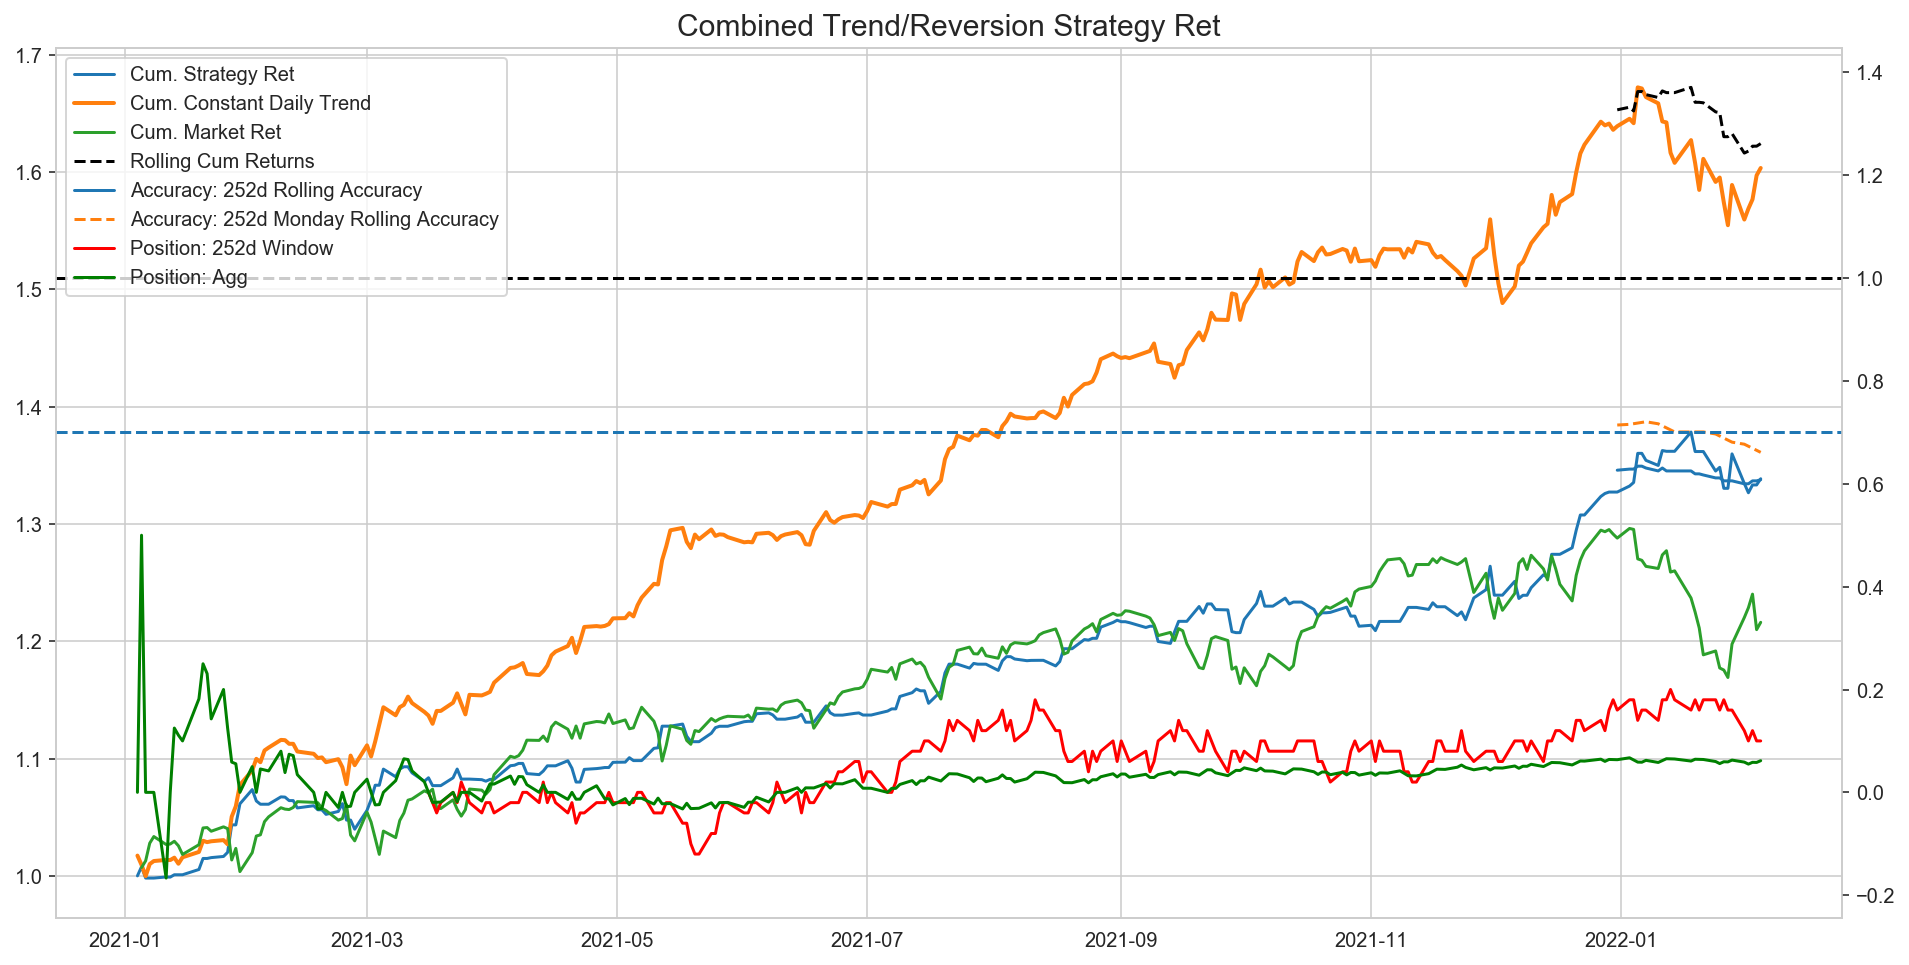

In [6]:
aa = combined_strategy_with_fri_conf(True,df_spx,0,0.000,rolling_window=252)
print(aa['Rolling 252d Cum. Strategy Ret'].min())

In [7]:
#sns.lmplot(data=combined_strategy_with_fri_conf(True,df_spx,0,0),x='Overnight % Return',y='Strategy Ret', hue='day_strat_dict',row='Year',height=7,aspect=2,sharex=False)

High          Low         Open        Close        VIX  \
Date                                                                        
2021-01-04  3769.989990  3662.709961  3764.610107  3700.649902  26.969999   
2021-01-05  3737.830078  3695.070068  3698.020020  3726.860107  25.340000   
2021-01-06  3783.040039  3705.340088  3712.199951  3748.139893  25.070000   
2021-01-07  3811.550049  3764.709961  3764.709961  3803.790039  22.370001   
2021-01-08  3826.689941  3783.600098  3815.050049  3824.679932  21.559999   
...                 ...          ...          ...          ...        ...   
2022-01-31  4516.890137  4414.020020  4431.790039  4515.549805  24.830000   
2022-02-01  4550.490234  4483.529785  4519.569824  4546.540039  21.959999   
2022-02-02  4595.310059  4544.319824  4566.390137  4589.379883  22.090000   
2022-02-03  4542.879883  4470.390137  4535.410156  4477.439941  24.350000   
2022-02-04  4539.660156  4451.500000  4482.790039  4500.529785  23.219999   

            Weekday  Year       C2C  O2C intraday  Close in 0 periods  ...  \
Date                                                                   ...   
2021-01-04        0  2021       NaN     -0.017136         3700.649902  ...   
2021-01-05        1  2021  0.007058      0.007769         3726.860107  ...   
2021-01-06        2  2021  0.005694      0.009635         3748.139893  ...   
2021-01-07        3  2021  0.014738      0.010327         3803.790039  ...   
2021-01-08        4  2021  0.005477      0.002521         3824.679932  ...   
...             ...   ...       ...           ...                 ...  ...   
2022-01-31        0  2022  0.018710      0.018723         4515.549805  ...   
2022-02-01        1  2022  0.006840      0.005950         4546.540039  ...   
2022-02-02        2  2022  0.009378      0.005022         4589.379883  ...   
2022-02-03        3  2022 -0.024693     -0.012864         4477.439941  ...   
2022-02-04        4  2022  0.005144      0.003949         4500.529785  ...   

            Monday Correct Strategy  Monday Position ON  Monday Accuracy  \
Date                                                                       
2021-01-04                      NaN                 NaN              NaN   
2021-01-05                      NaN                 NaN              NaN   
2021-01-06                      NaN                 NaN              NaN   
2021-01-07                      NaN                 NaN              NaN   
2021-01-08                      0.0                 0.0              NaN   
...                             ...                 ...              ...   
2022-01-31                      0.0                 1.0              0.0   
2022-02-01                      0.0                 1.0              0.0   
2022-02-02                      0.0                 1.0              0.0   
2022-02-03                      0.0                 1.0              0.0   
2022-02-04                      0.0                 1.0              0.0   

            Monday Accuracy fillna  Monday Rolling Accuracy  \
Date                                                          
2021-01-04                0.680162                      NaN   
2021-01-05                0.680162                      NaN   
2021-01-06                0.680162                      NaN   
2021-01-07                0.680162                      NaN   
2021-01-08                0.680162                      NaN   
...                            ...                      ...   
2022-01-31                0.000000                 0.676997   
2022-02-01                0.000000                 0.673029   
2022-02-02                0.000000                 0.669060   
2022-02-03                0.000000                 0.665092   
2022-02-04                0.000000                 0.661124   

            Strategy Cum. Log Ret : Holding Period = 0  \
Date                                                     
2021-01-04                                    1.000000   
2021-01-05         

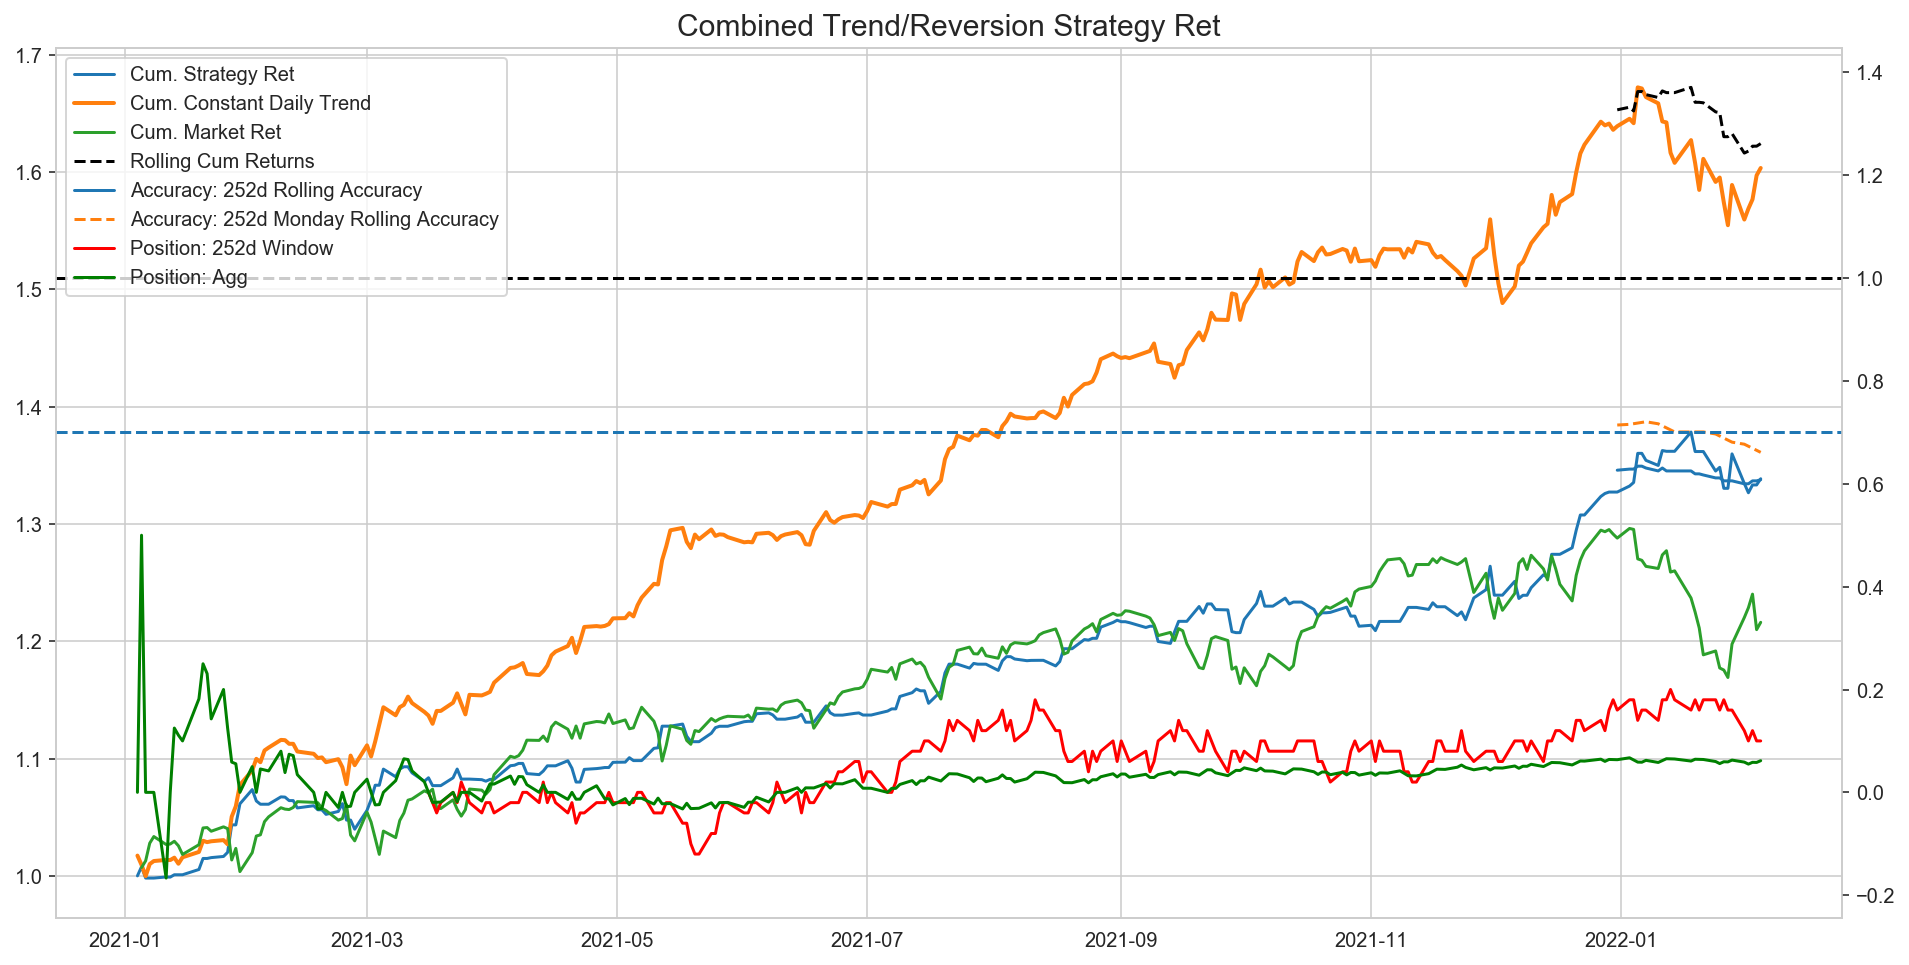

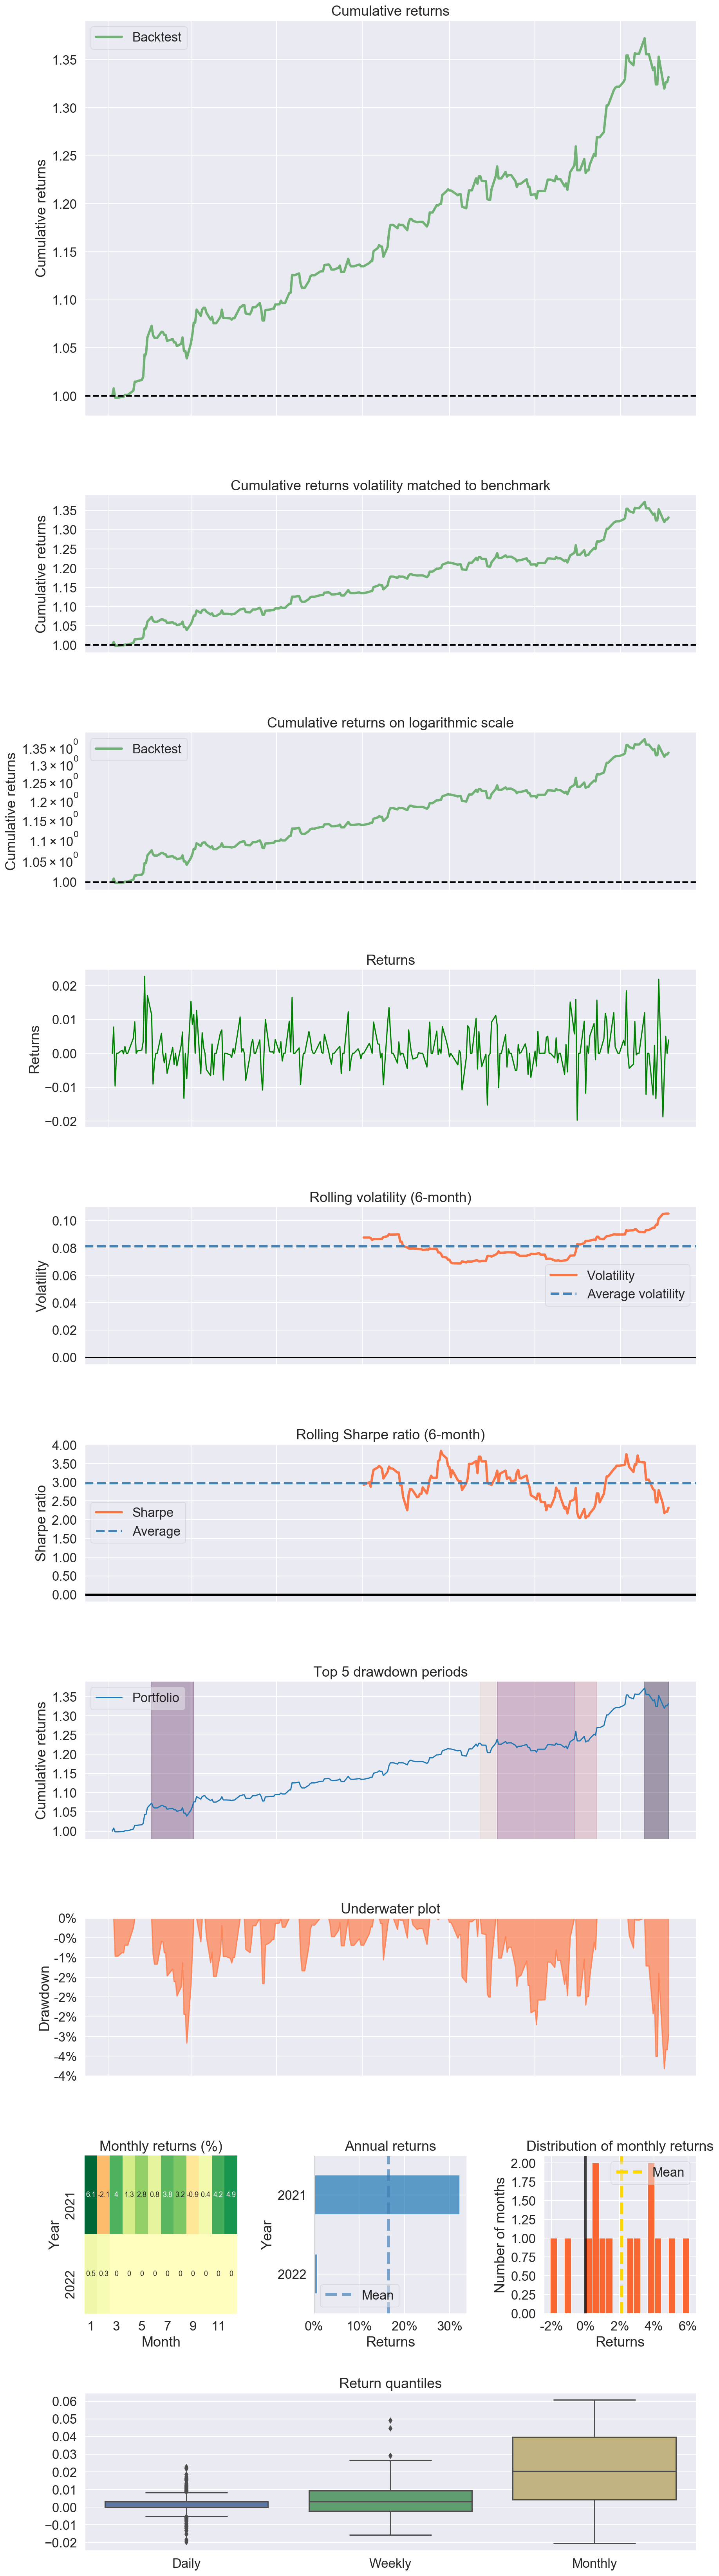

In [8]:
log_returns = combined_strategy_with_fri_conf(log=True,df=df_spx,holding_period=0,overnight_threshold=0.0000,rolling_window=252)
pf.create_returns_tear_sheet(log_returns['Strategy Ret'])
log_returns

High          Low         Open        Close  Weekday  Year  \
Date                                                                            
2021-01-04  3609.909912  3548.310059  3565.679932  3564.389893        0  2021   
2021-01-05  3574.979980  3524.629883  3554.239990  3547.850098        1  2021   
2021-01-06  3620.570068  3547.449951  3559.810059  3611.080078        2  2021   
2021-01-07  3635.639893  3604.129883  3621.159912  3622.419922        3  2021   
2021-01-08  3657.830078  3630.709961  3632.139893  3645.050049        4  2021   
...                 ...          ...          ...          ...      ...   ...   
2022-01-31  4200.830078  4134.069824  4161.770020  4174.600098        0  2022   
2022-02-01  4232.439941  4184.629883  4184.629883  4224.450195        1  2022   
2022-02-02  4259.279785  4222.049805  4242.740234  4222.049805        2  2022   
2022-02-03  4215.410156  4141.020020  4215.410156  4141.020020        3  2022   
2022-02-04  4167.870117  4067.510010  4154.750000  4086.580078        4  2022   

                 C2C  O2C intraday  Close in 0 periods  UP|DOWN  ...  \
Date                                                             ...   
2021-01-04       NaN     -0.000362         3564.389893       -1  ...   
2021-01-05 -0.004651     -0.001799         3547.850098       -1  ...   
2021-01-06  0.017665      0.014300         3611.080078        1  ...   
2021-01-07  0.003135      0.000348         3622.419922        1  ...   
2021-01-08  0.006228      0.003548         3645.050049        1  ...   
...              ...           ...                 ...      ...  ...   
2022-01-31  0.009069      0.003078         4174.600098        1  ...   
2022-02-01  0.011871      0.009471         4224.450195        1  ...   
2022-02-02 -0.000568     -0.004889         4222.049805       -1  ...   
2022-02-03 -0.019379     -0.017805         4141.020020       -1  ...   
2022-02-04 -0.013234     -0.016544         4086.580078       -1  ...   

            Monday Correct Strategy  Monday Position ON  Monday Accuracy  \
Date                                                                       
2021-01-04                      NaN                 NaN              NaN   
2021-01-05                      NaN                 NaN              NaN   
2021-01-06                      NaN                 NaN              NaN   
2021-01-07                      NaN                 NaN              NaN   
2021-01-08                      0.0                 0.0              NaN   
...                             ...                 ...              ...   
2022-01-31                      1.0                 1.0              1.0   
2022-02-01                      1.0                 1.0              1.0   
2022-02-02                      1.0                 1.0              1.0   
2022-02-03                      1.0                 1.0              1.0   
2022-02-04                      1.0                 1.0              1.0   

            Monday Accuracy fillna  Monday Rolling Accuracy  \
Date                                                          
2021-01-04                0.614232                      NaN   
2021-01-05                0.614232                      NaN   
2021-01-06                0.614232                      NaN   
2021-01-07                0.614232                      NaN   
2021-01-08                0.614232                      NaN   
...                            ...                      ...   
2022-01-31                1.000000                 0.620237   
2022-02-01                1.000000                 0.620237   
2022-02-02                1.000000                 0.620237   
2022-02-03                1.000000                 0.624205   
2022-02-04                1.000000                 0.628173   

            Strategy Cum. Log Ret : Holding Period = 0  \
Date                                                     
2021-01-04                                    1.000000   
2021-01-05                                   

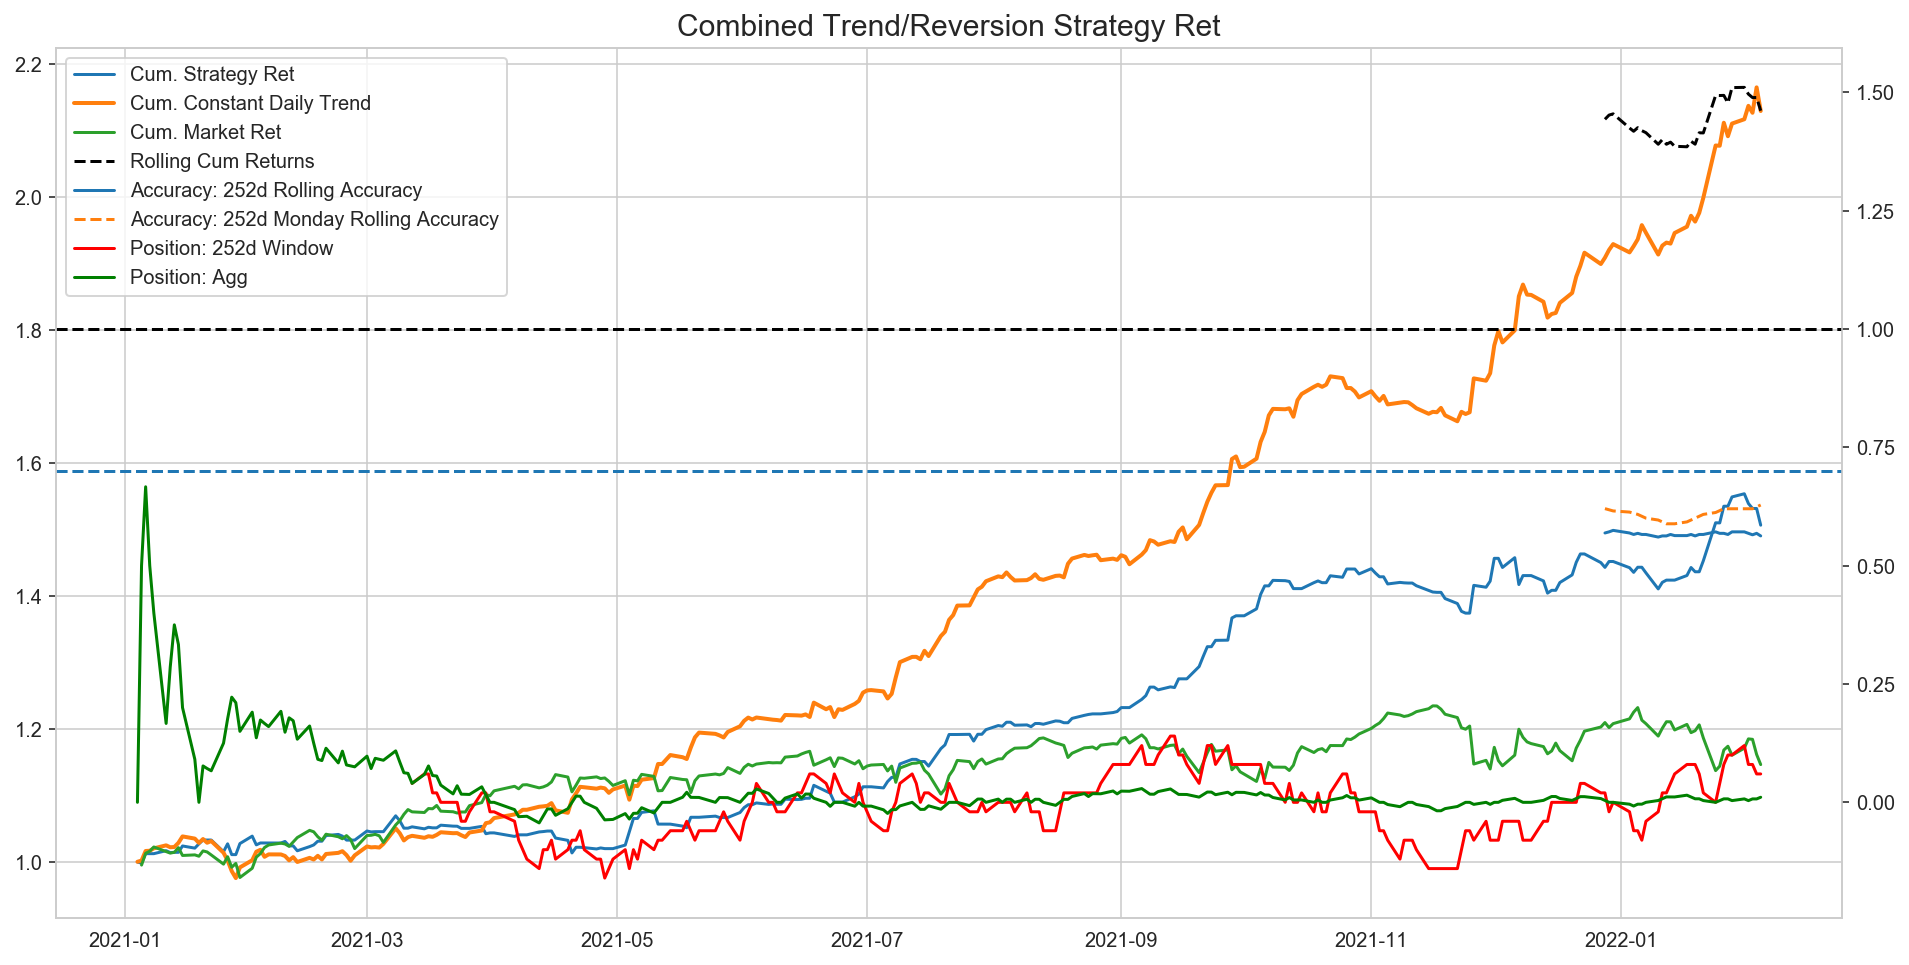

In [9]:
#SX5E
log_returns_sx5e = combined_strategy_with_fri_conf(log=True,df=df_sx5e,holding_period=0,overnight_threshold=0.0000,rolling_window=252)
#pf.create_returns_tear_sheet(log_returns_sx5e['Strategy Ret'])
log_returns_sx5e

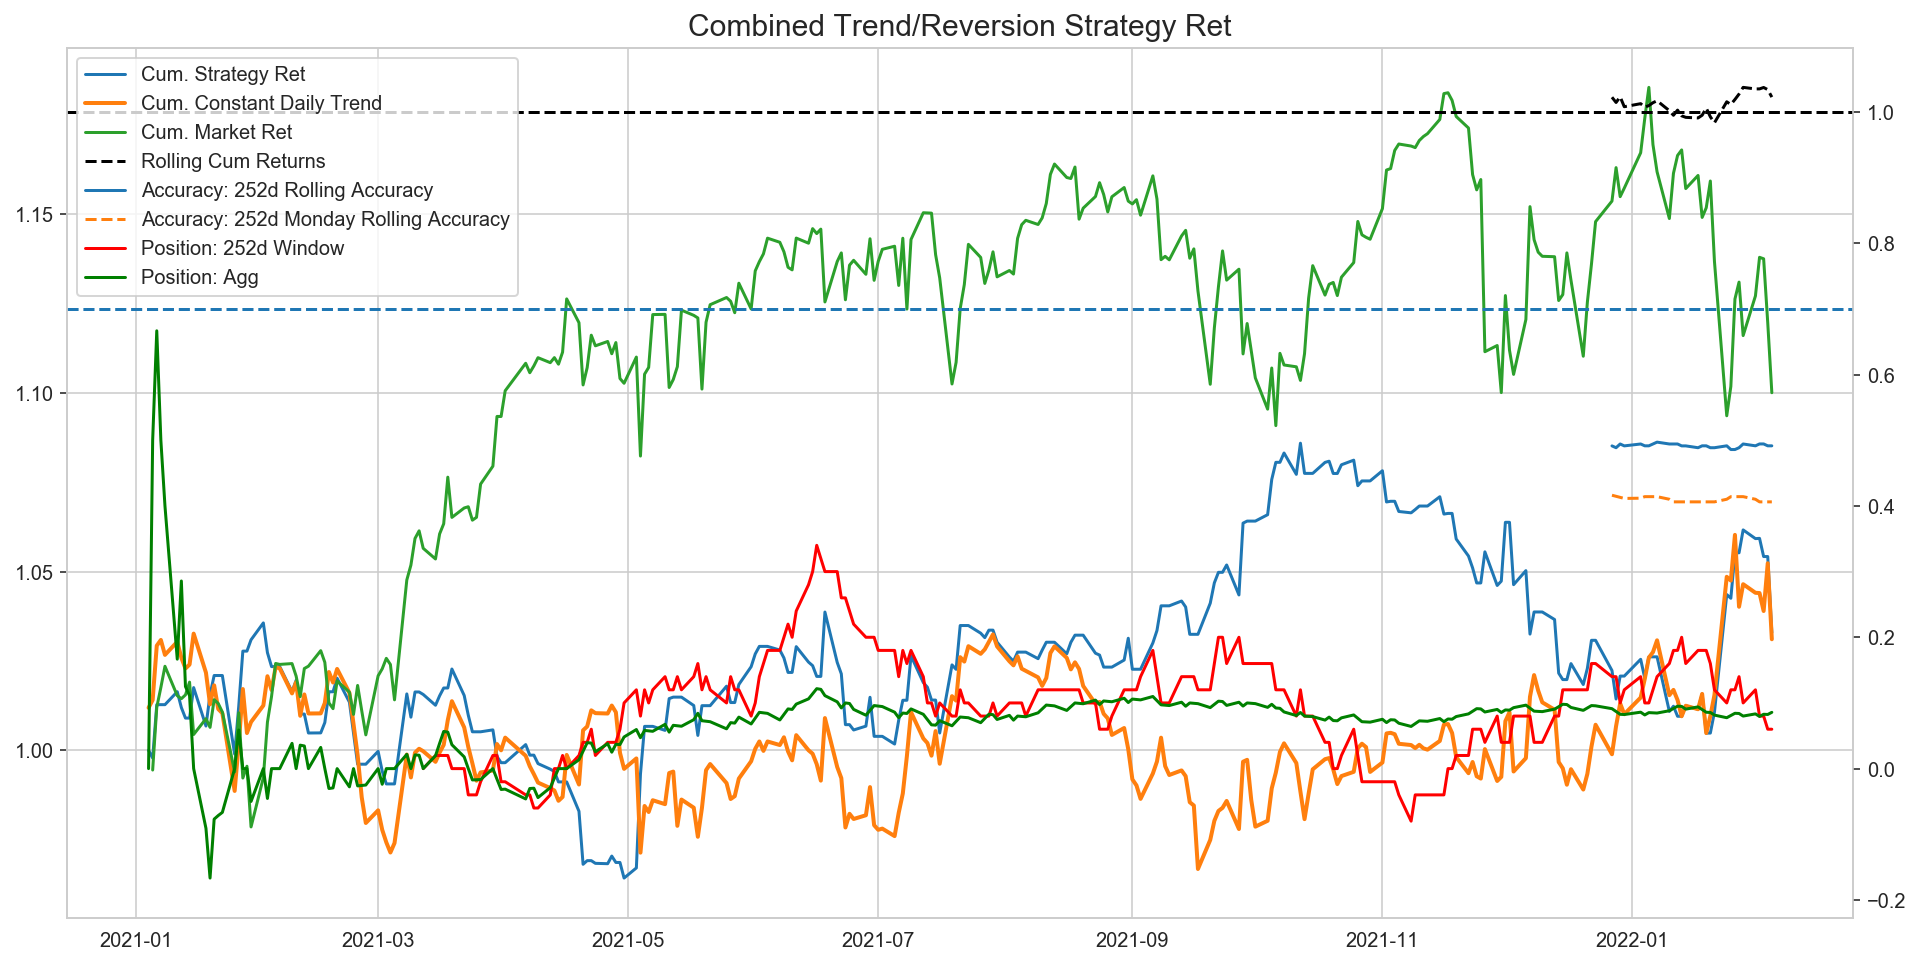

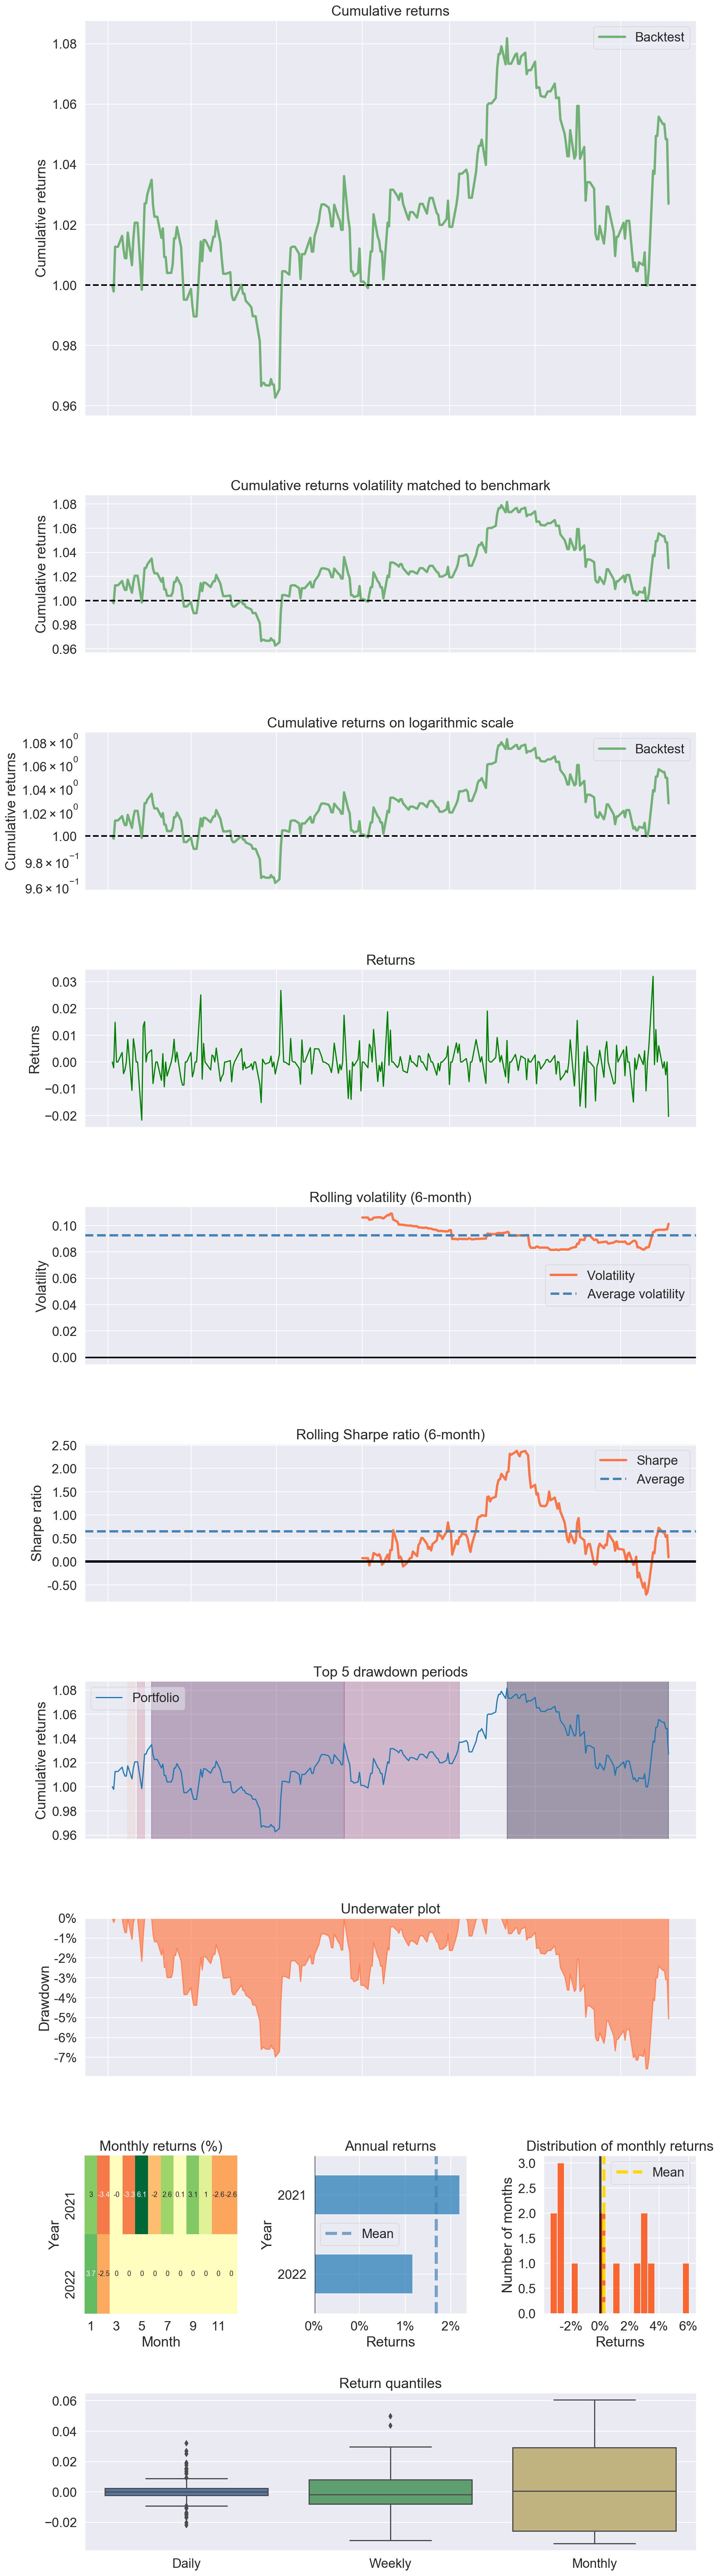

In [10]:
#DAX
log_returns_dax = combined_strategy_with_fri_conf(log=True,df=df_dax,holding_period=0,overnight_threshold=0.0000,rolling_window=252)
pf.create_returns_tear_sheet(log_returns_dax['Strategy Ret'])

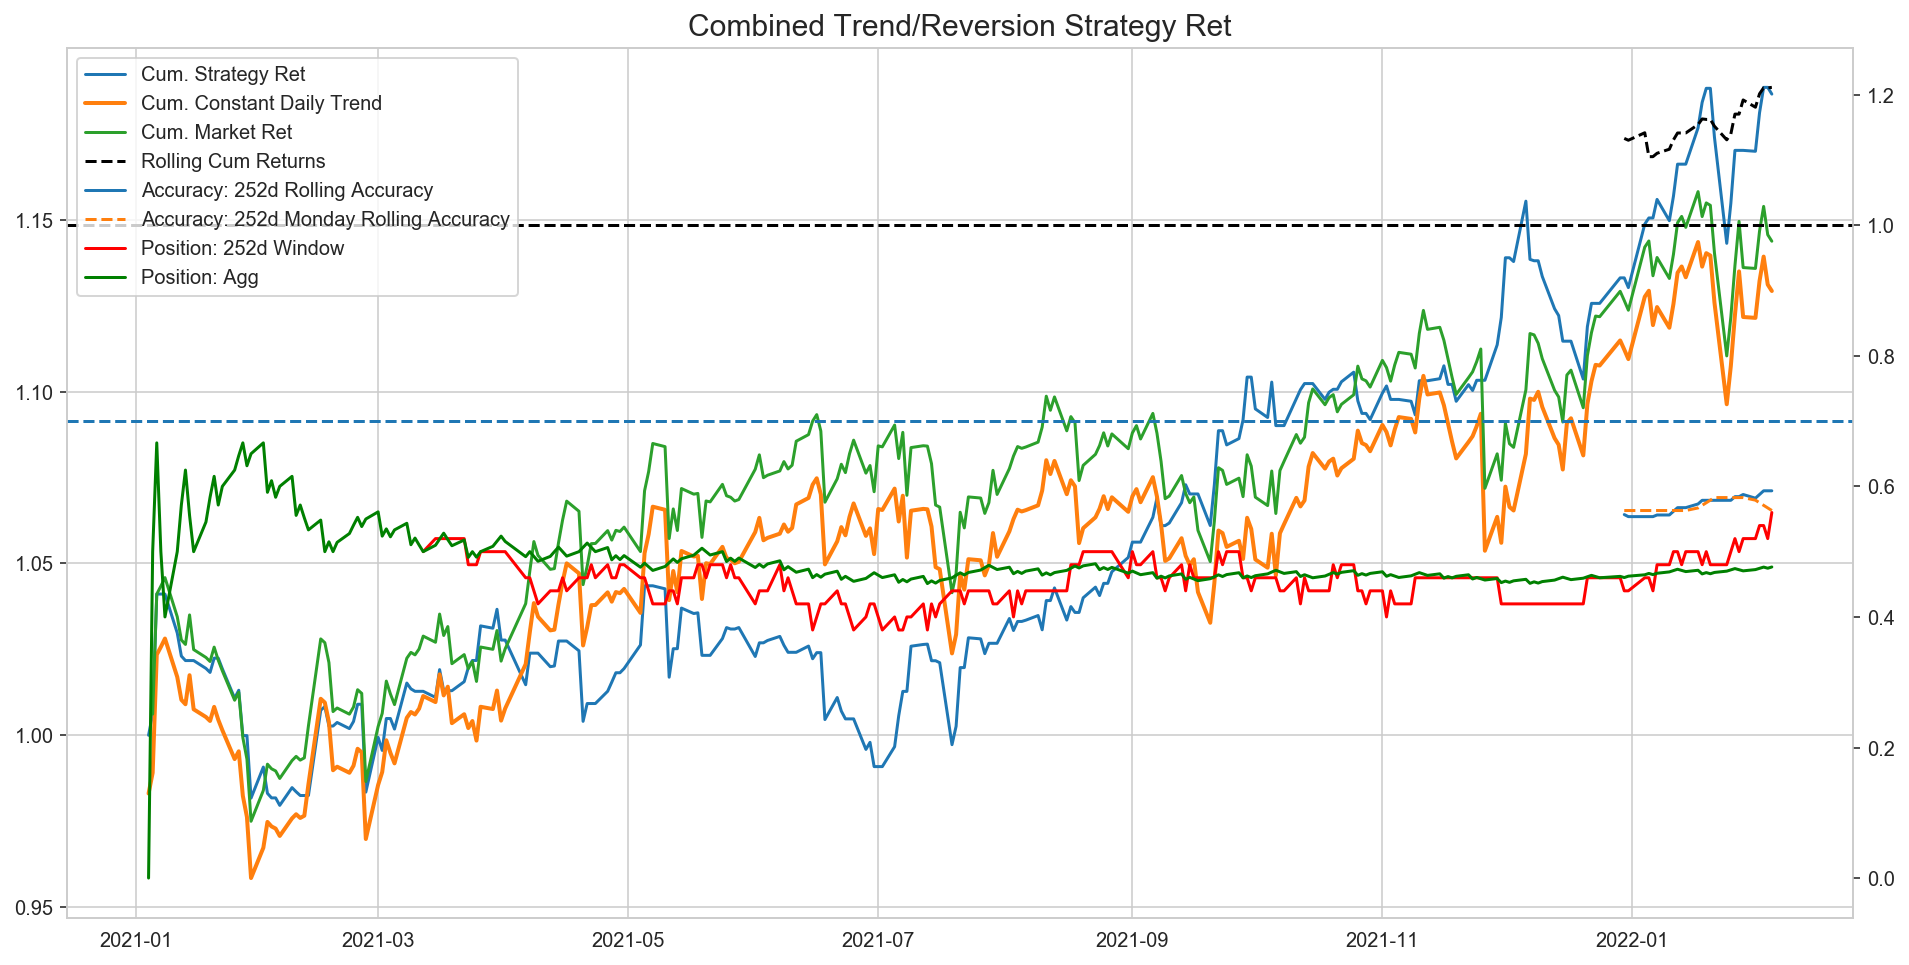

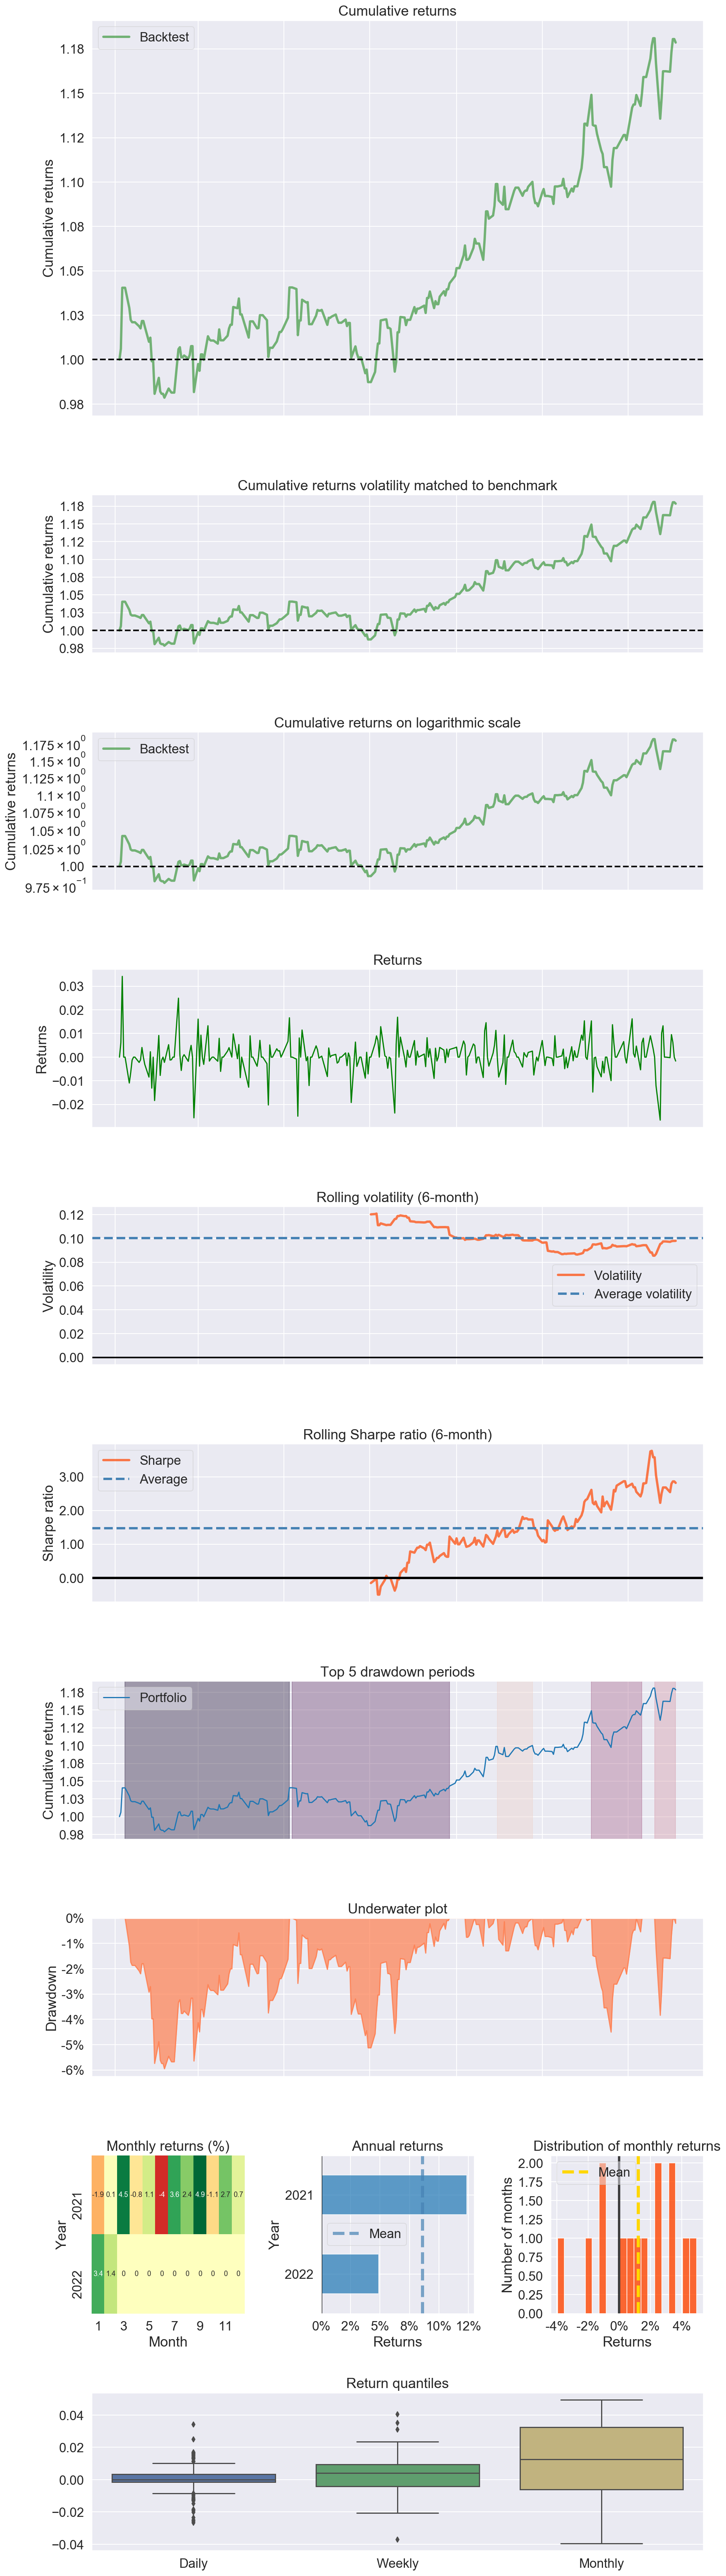

In [11]:
#FTSE NONSENSE as OPEN T = CLOSE T-1
log_returns_ftse = combined_strategy_with_fri_conf(log=True,df=df_ftse,holding_period=0,overnight_threshold=0.0000,rolling_window=252)
pf.create_returns_tear_sheet(log_returns_ftse['Strategy Ret'])

In [12]:
df_ftse.iloc[:,:15]

Open     High      Low    Close  Weekday  Year       C2C  \
Date                                                                      
2021-01-04  6460.52  6662.66  6460.52  6571.88        0  2021       NaN   
2021-01-05  6571.88  6622.77  6544.25  6612.25        1  2021  0.006124   
2021-01-06  6612.25  6859.14  6611.87  6841.86        2  2021  0.034136   
2021-01-07  6841.86  6903.61  6795.11  6856.96        3  2021  0.002205   
2021-01-08  6856.96  6886.34  6836.08  6873.26        4  2021  0.002374   
...             ...      ...      ...      ...      ...   ...       ...   
2022-01-31  7466.07  7523.95  7450.89  7464.37        0  2022 -0.000228   
2022-02-01  7464.37  7549.29  7463.01  7535.78        1  2022  0.009521   
2022-02-02  7535.78  7605.64  7535.78  7583.00        2  2022  0.006247   
2022-02-03  7583.00  7605.75  7528.69  7528.84        3  2022 -0.007168   
2022-02-04  7528.84  7599.73  7497.21  7516.40        4  2022 -0.001654   

            O2C intraday  Close in 0 periods  UP|DOWN  UP|DOWN T-1  \
Date                                                                 
2021-01-04      0.017090             6571.88       -1           -1   
2021-01-05      0.006124             6612.25        1           -1   
2021-01-06      0.034136             6841.86        1            1   
2021-01-07      0.002205             6856.96        1            1   
2021-01-08      0.002374             6873.26        1            1   
...                  ...                 ...      ...          ...   
2022-01-31     -0.000228             7464.37       -1           -1   
2022-02-01      0.009521             7535.78        1           -1   
2022-02-02      0.006247             7583.00        1            1   
2022-02-03     -0.007168             7528.84       -1            1   
2022-02-04     -0.001654             7516.40       -1           -1   

            Overnight % Return  Overnight UP|DOWN  M Pos  Tu Pos  
Date                                                              
2021-01-04                 NaN                 -1      0     0.0  
2021-01-05                 0.0                  1      0     1.0  
2021-01-06                 0.0                  1      0     0.0  
2021-01-07                 0.0                  1      0     0.0  
2021-01-08                 0.0                  1      0     0.0  
...                        ...                ...    ...     ...  
2022-01-31                 0.0                  1      1     0.0  
2022-02-01                 0.0                  1      0     1.0  
2022-02-02                 0.0                  1      0     0.0  
2022-02-03                 0.0                  1      0     0.0  
2022-02-04                 0.0                  1      0     0.0  

[277 rows x 15 columns]

In [13]:
log_returns_sx5e.columns

Index(['High', 'Low', 'Open', 'Close', 'Weekday', 'Year', 'C2C',
       'O2C intraday', 'Close in 0 periods', 'UP|DOWN', 'UP|DOWN T-1',
       'Overnight % Return', 'Overnight UP|DOWN', 'M Pos', 'Tu Pos', 'W Pos',
       'Th Pos', 'F Pos', 'day_strat_dict', 'Position',
       'Future Holding Period Ret', 'Future Holding Period Points',
       'Strategy Ret', 'Constant Trend Follow Ret', 'Strategy Points', 'Trend',
       'Trend Ret', 'Mean', 'Mean Ret', 'Tr&M_signal', 'Tr&M_signal Ret',
       'Tr&M_s_dir', 'Tr&M_s_dir Ret', 'Hindsight Ideal Trend Pos',
       'Hindsight Ideal Mean Pos', 'Correct Strategy',
       'Correct Strategy fillna', 'Position ON', 'Strategy Accuracy',
       'Monday Correct Strategy', 'Monday Position ON', 'Monday Accuracy',
       'Monday Accuracy fillna', 'Monday Rolling Accuracy',
       'Strategy Cum. Log Ret : Holding Period = 0',
       'Constant Daily Trend Follow Cum. Log Ret', 'Market Ret',
       'Cum. Market Ret', 'Rolling 252d Cum. Strategy Ret'],
 

In [14]:
log_returns_sx5e_2020 = log_returns_sx5e[log_returns_sx5e.index.year>2019]

In [15]:
log_returns_sx5e_2020.groupby([log_returns_sx5e_2020.index.weekday])['Trend'].value_counts(normalize=True)

Date  Trend
0     True     0.618182
      False    0.381818
1     True     0.631579
      False    0.368421
2     True     0.614035
      False    0.385965
3     True     0.589286
      False    0.410714
4     True     0.629630
      False    0.370370
Name: Trend, dtype: float64

In [16]:
log_returns.groupby([df_spx.index.year,'Correct Strategy'])['Strategy Ret'].describe()

count      mean       std       min       25%  \
Date Correct Strategy                                                  
2021 0.0                65.0 -0.004763  0.004014 -0.019698 -0.006251   
     1.0               109.0  0.005437  0.004715  0.000047  0.001591   
2022 0.0                 8.0 -0.008814  0.006216 -0.018723 -0.012547   
     1.0                 9.0  0.008780  0.007238  0.002286  0.003848   

                            50%       75%       max  
Date Correct Strategy                                
2021 0.0              -0.004040 -0.001548 -0.000032  
     1.0               0.004094  0.008580  0.022685  
2022 0.0              -0.009035 -0.004103 -0.000474  
     1.0               0.005022  0.011973  0.021821

In [17]:
log_returns.groupby([df_spx.index.year,'Position'])[['Correct Strategy','Strategy Ret']].mean()

Correct Strategy  Strategy Ret
Date Position                                
2021 -1.0              0.607595      0.001389
      0.0                   NaN      0.000000
      1.0              0.642105      0.001825
2022 -1.0              0.500000     -0.000642
      0.0                   NaN      0.000000
      1.0              0.555556      0.001517

In [18]:
log_returns.groupby(['Year','Correct Strategy'])['Strategy Ret'].apply(lambda x: np.exp(x.sum()))

Year  Correct Strategy
2021  0.0                 0.733736
      1.0                 1.808787
2022  0.0                 0.931919
      1.0                 1.082231
Name: Strategy Ret, dtype: float64

In [19]:
log_returns.groupby(['Year'])['Strategy Ret'].apply(lambda x: np.exp(x.sum()))

Year
2021    1.327172
2022    1.008551
Name: Strategy Ret, dtype: float64

In [20]:
log_returns.groupby(['Year','Weekday'])['Correct Strategy'].value_counts(normalize=True).tail(50)

Year  Weekday  Correct Strategy
2021  0        1.0                 0.717391
               0.0                 0.282609
      1        1.0                 0.673077
               0.0                 0.326923
      2        1.0                 0.557692
               0.0                 0.442308
      4        0.0                 0.500000
               1.0                 0.500000
2022  0        0.0                 0.750000
               1.0                 0.250000
      1        1.0                 0.800000
               0.0                 0.200000
      2        0.0                 0.600000
               1.0                 0.400000
      4        1.0                 0.666667
               0.0                 0.333333
Name: Correct Strategy, dtype: float64

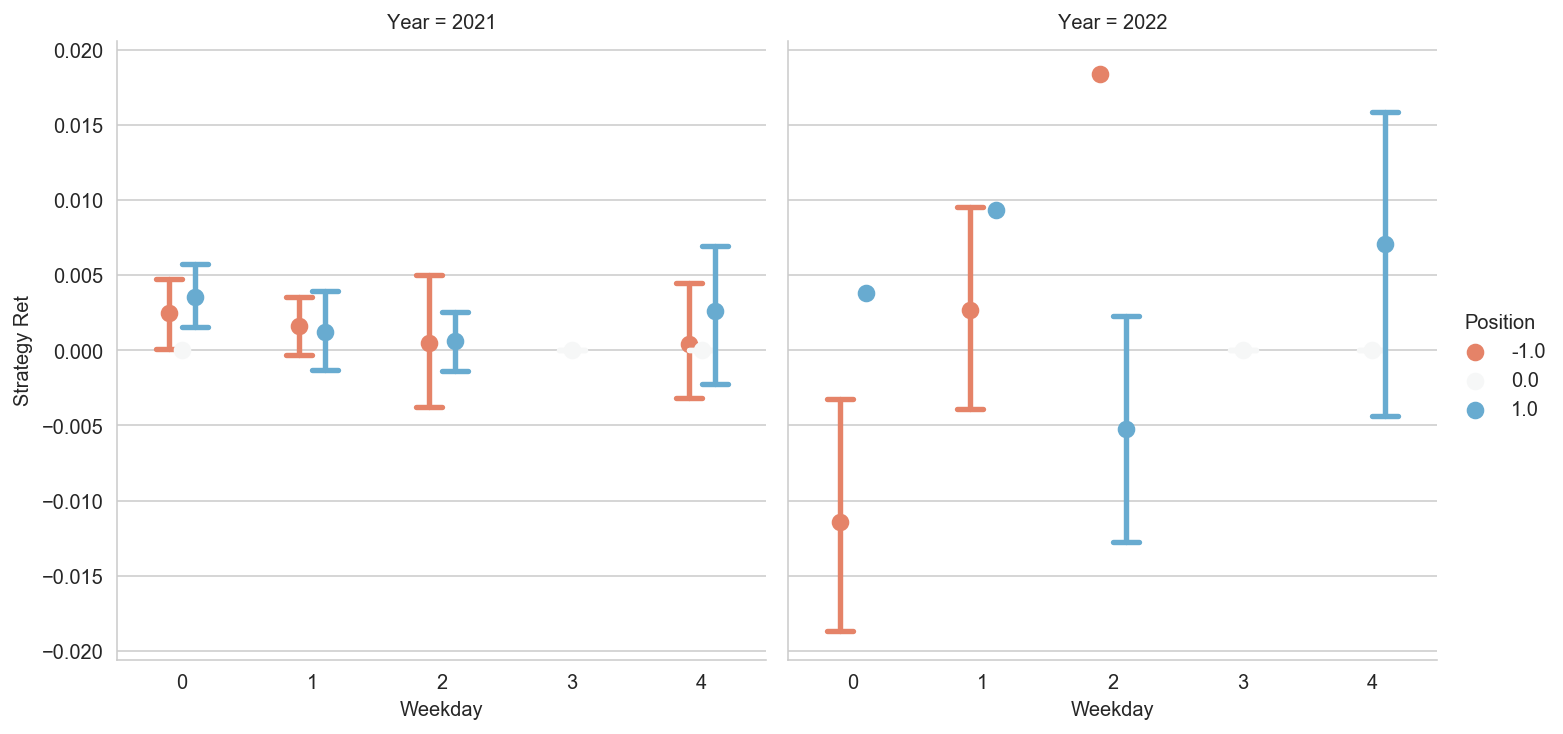

In [21]:
sns.set_style('whitegrid')
sns.catplot(kind='point',x='Weekday',y='Strategy Ret',data=df_spx,hue='Position',col='Year',capsize=0.2,legend=True,dodge=0.2,join=False,ci=95,palette='RdBu')

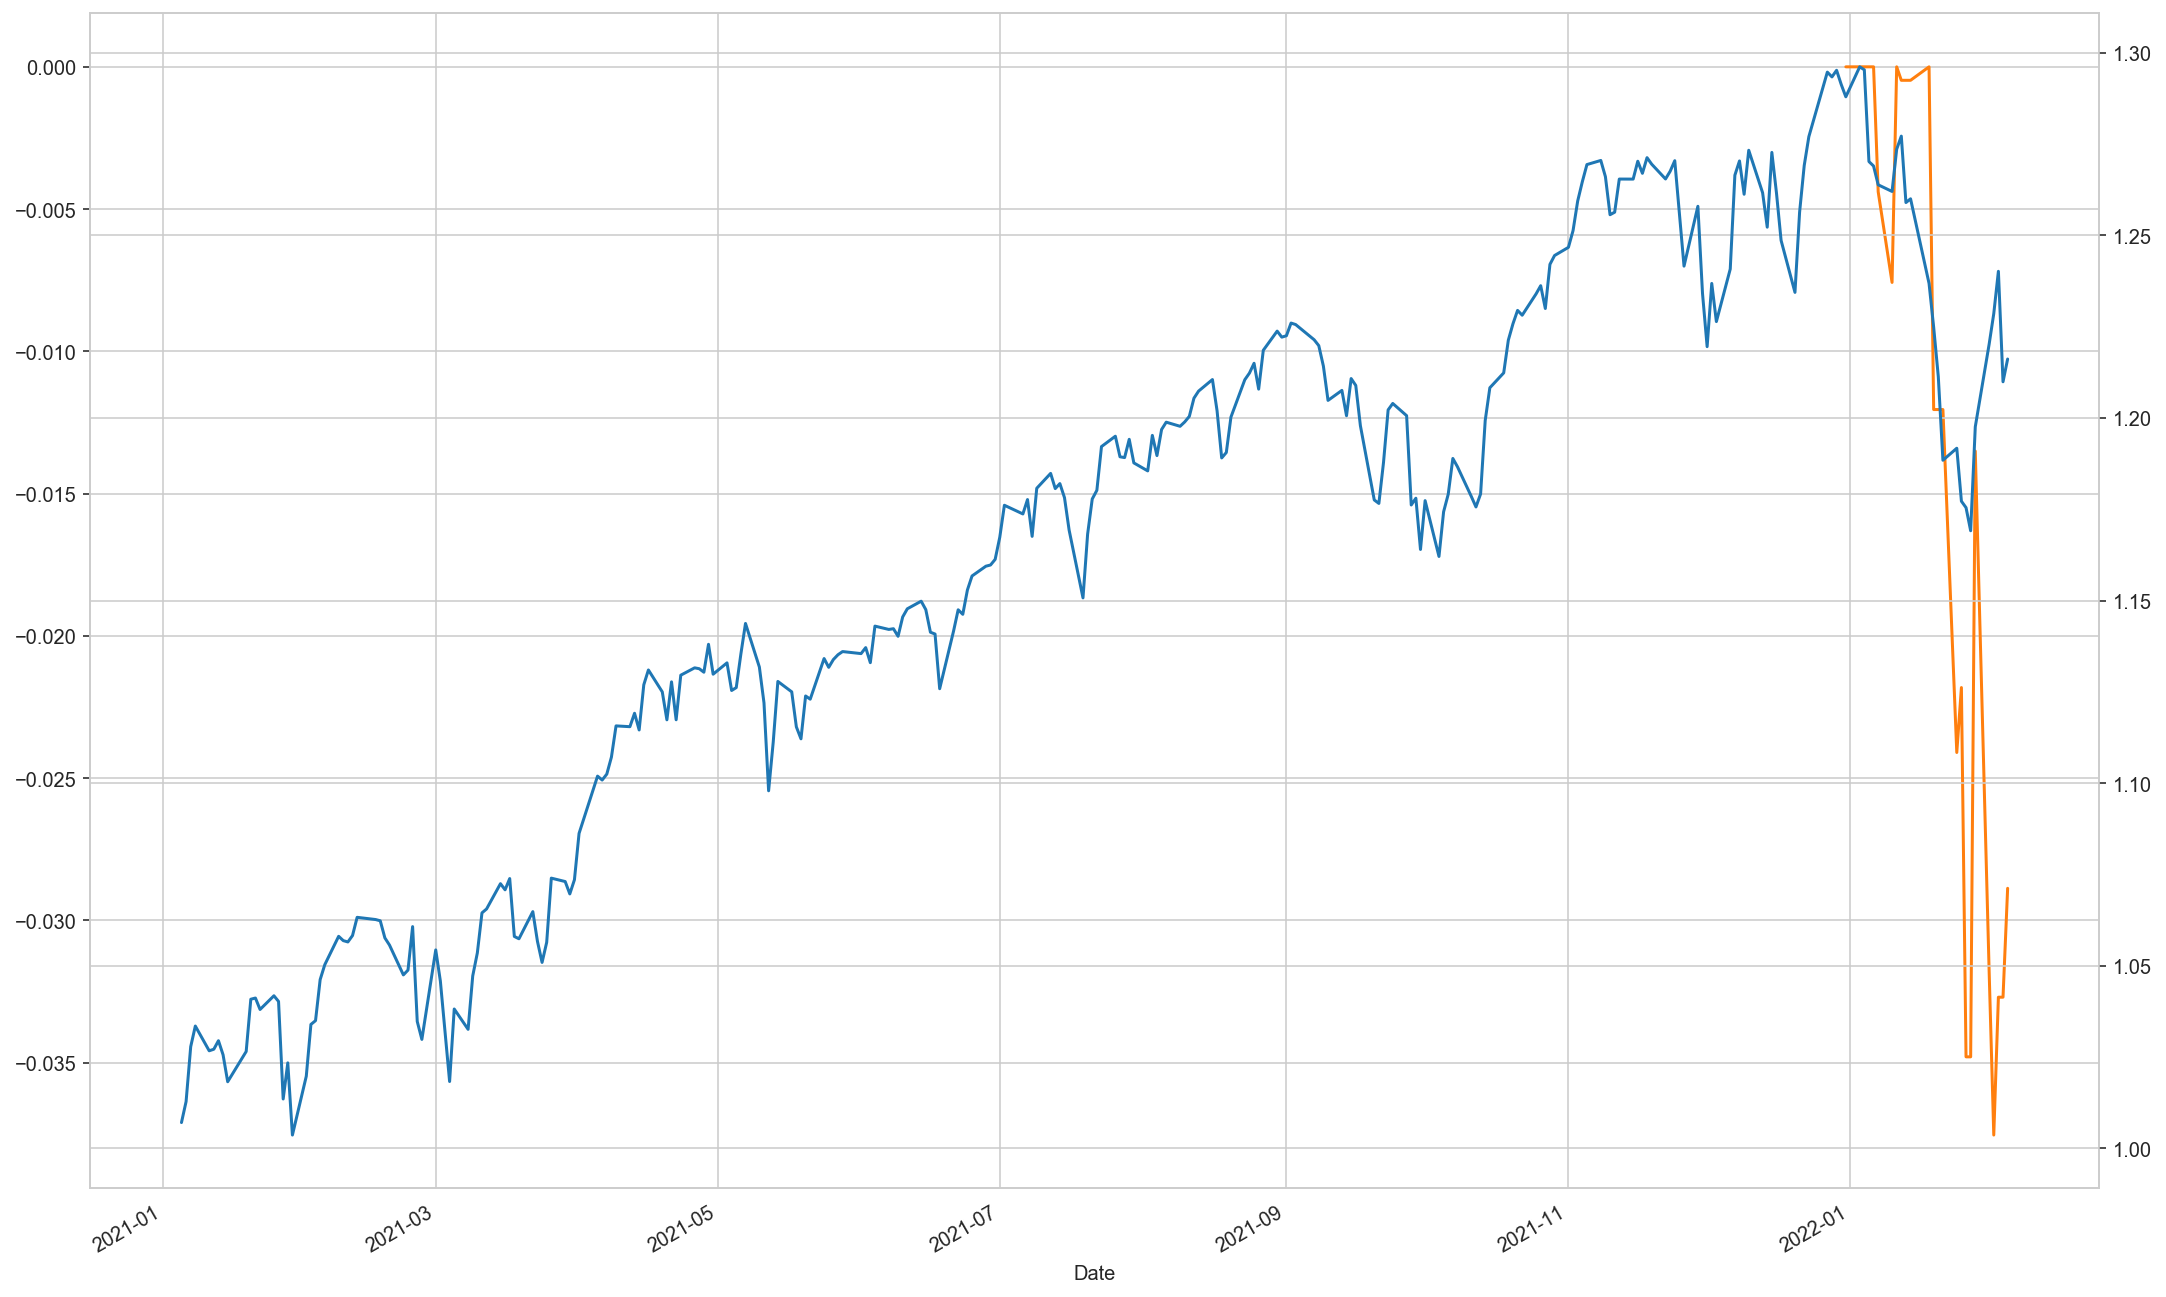

In [22]:
rolling_window=252
Roll_Max = df_spx['Strategy Cum. Log Ret : Holding Period = 0'].rolling(rolling_window).max()
Drawdown = df_spx['Strategy Cum. Log Ret : Holding Period = 0'] / Roll_Max - 1.0
Max_Drawdown = Drawdown.rolling(rolling_window).min()
df_spx['Cum. Market Ret'].plot(secondary_y=True)

Drawdown.plot(figsize=(18,12))
Max_Drawdown.plot()
plt.show()